## An exploration of covid case data

I'm looking to explore the covid case data, particularly from a perspective of fitting a function to the data, out of both an interest in it's behaviour and possibly enabling future predictions for outbreaks.

### Overview

<ul>
    <li>Fitting an expontential growth model</li>
    <li>Fitting a logistic growth model</li>
    <li>A Comparison with the UK and observing key events influence</li>
    
</ul>

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import math

covid_data = pd.read_csv('total-cases-covid-19.csv')


In [2]:
covid_data

,Entity,Code,Date,Total confirmed cases of COVID-19 (cases)
0,Afghanistan,AFG,"Dec 31, 2019",0
1,Afghanistan,AFG,"Jan 1, 2020",0
2,Afghanistan,AFG,"Jan 2, 2020",0
3,Afghanistan,AFG,"Jan 3, 2020",0
4,Afghanistan,AFG,"Jan 4, 2020",0
...,...,...,...,...
29469,Zimbabwe,ZWE,"Jun 25, 2020",530
29470,Zimbabwe,ZWE,"Jun 26, 2020",551
29471,Zimbabwe,ZWE,"Jun 27, 2020",561
29472,Zimbabwe,ZWE,"Jun 28, 2020",567


### Fitting an expontential growth model

First we will just look at how we need to transform the data to do this, getting some easy x values for graphing, but also we want our charts to start from the first cases. We don't care about the months worth of 0 cases in Australia.


In [3]:
# make an easier named column
if 'Total confirmed cases of COVID-19 (cases)'  in covid_data.columns:
    covid_data['cases'] = covid_data['Total confirmed cases of COVID-19 (cases)']
    del covid_data['Total confirmed cases of COVID-19 (cases)']
    

#get Aus covid data form where cases start
covid_data['Date'] =pd.to_datetime(covid_data['Date'])
covid_data = covid_data[covid_data['Entity'] == 'Australia']
covid_data = covid_data[covid_data['cases'] > 0]
covid_data.sort_values(by=['Date'])

#save copy for later
original_covid_data = covid_data.copy(deep=True)


#cut off for data (so we can predict after this date)
covid_data = covid_data[covid_data['Date'] < '2020-06-15']


# make easier x value thant Date
covid_data['time'] = np.linspace(1, len(covid_data), len(covid_data))


covid_data


,Entity,Code,Date,cases,time
1825,Australia,AUS,2020-01-25,1,1.0
1826,Australia,AUS,2020-01-26,4,2.0
1827,Australia,AUS,2020-01-27,4,3.0
1828,Australia,AUS,2020-01-28,4,4.0
1829,Australia,AUS,2020-01-29,4,5.0
...,...,...,...,...,...
1962,Australia,AUS,2020-06-10,7267,138.0
1963,Australia,AUS,2020-06-11,7276,139.0
1964,Australia,AUS,2020-06-12,7285,140.0
1965,Australia,AUS,2020-06-13,7290,141.0


We can see the actual first case date here, but we will mainly plot along x with number of days for ease.

In [4]:
aus_first_case_date = covid_data.iloc[0]
def get_date_simple_format_str(date):
    return aus_first_case_date['Date'].strftime("%d-%m-%y")
aus_first_case_date

Entity              Australia
Code                      AUS
Date      2020-01-25 00:00:00
cases                       1
time                        1
Name: 1825, dtype: object

In [5]:
def plot_addons(title, x_axis, y_axis):
    plt.title(title)
    plt.xlabel(x_axis)
    plt.ylabel(y_axis)


AUS infections vs time

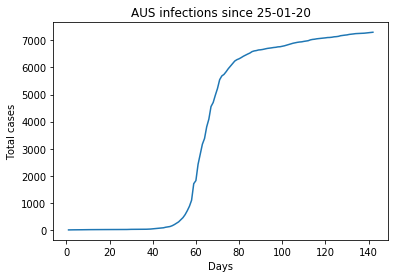

In [6]:
plt.plot(covid_data['time'], covid_data['cases']);
plot_addons('AUS infections since ' + get_date_simple_format_str(aus_first_case_date) , 'Days', 'Total cases');

Now we want to fit a curve to this data that resembles exponential growth, i.e. y=a*e^bx.  
One way to do this, is we can transform our y to resemble a linear curve, then we can fit a linear regression to the new data.
This would end up with a prediction model: log(y) = a*x + c.
We can exponentiate the y to get the original value.

https://towardsdatascience.com/modeling-exponential-growth-49a2b6f22e1f

In [7]:
# get log transform for exp regression
new_df = pd.DataFrame({'time': covid_data['time'], 
                      'infections': covid_data['cases'],
                      'log_infections': np.array(np.log(covid_data['cases']))})
new_df.head(3)

,time,infections,log_infections
1825,1.0,1,0.000000
1826,2.0,4,1.386294
1827,3.0,4,1.386294


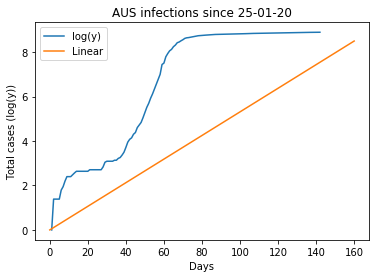

In [8]:
lin_Y = np.linspace(0, 8.5, 160)
plt.plot(new_df['time'], new_df['log_infections'], label = 'log(y)');
plt.plot(np.linspace(0, 160, 160), lin_Y, label='Linear')
plt.legend()
plot_addons('AUS infections since ' + get_date_simple_format_str(aus_first_case_date) , 'Days', 'Total cases (log(y))');

This isn't a good sign, our 'linearly transoformed' data of log(y), is not very well transofrmed. Regardless, let's try and fit an exponential function as best we can.
This will work by first fitting a simply linear model using the 'statsmodel' library, this will fit a line (like above) but Minimizing Least-Squares-Error to have a line that fits the data best. 

In [9]:
#https://towardsdatascience.com/modeling-exponential-growth-49a2b6f22e1f
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm

added_constant = False

X = new_df.time
if added_constant:
    X = sm.add_constant(X)

mod = sm.OLS(new_df.log_infections, X)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:         log_infections   R-squared (uncentered):                   0.950
Model:                            OLS   Adj. R-squared (uncentered):              0.950
Method:                 Least Squares   F-statistic:                              2682.
Date:                Tue, 07 Jul 2020   Prob (F-statistic):                    1.20e-93
Time:                        13:36:17   Log-Likelihood:                         -267.49
No. Observations:                 142   AIC:                                      537.0
Df Residuals:                     141   BIC:                                      539.9
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
time           0.0842      0.002     51.790      0.000       0.081       0.087
==============================================================================
Omnibus:                        9.604   Durbin-Watson:                   0.008
Prob(Omnibus):                  0.008   Jarque-Bera (JB):               10.336
Skew:                          -0.645   Prob(JB):                      0.00570
Kurtosis:                       2.715   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [10]:
par = res.params
par

time    0.084232
dtype: float64

In [11]:
# log(y) equation
if added_constant:    
    c = par[0]
    b = par[1]
    print('constant {}'.format(math.exp(c)))
    print('coefficient {}'.format(math.exp(b)))
else:
    print('coefficient {}'.format(math.exp(par)))

coefficient 1.0878817132647


In [12]:
#    log(y) = log(b*x) + log(c)
# => exp(log(y)) = exp(log(b) + log(x)) + exp(log(c))
#                let log(x) = t
#                = exp(log(b))*t) + exp(log(c))
#              y = c + b*e^t

def final_model(T, added_constant):
    
    if added_constant:
        c = par[0]
        b = par[1]
        Y = math.exp(c) + (math.exp(b)**T)
    else:
        b = par
        Y =(math.exp(b)**T)
    return Y


In [13]:
T = np.linspace(1, len(covid_data['cases']), len(covid_data['cases']))
Y = final_model(T, added_constant)

In [14]:
covid_data['Date']

1825   2020-01-25
1826   2020-01-26
1827   2020-01-27
1828   2020-01-28
1829   2020-01-29
          ...    
1962   2020-06-10
1963   2020-06-11
1964   2020-06-12
1965   2020-06-13
1966   2020-06-14
Name: Date, Length: 142, dtype: datetime64[ns]

##### fitting log curve to our data (log model)

Now we will plot this newly modelled data against the actual data:
The linear model we created from our log(y), will need to be converted back. In terms of the original y. <br>
log(y) = log(b*x) + log(c)<br>
exp(log(y)) = exp(log(b) + log(x)) + exp(log(c))         -- >let log(x) = t)<br>
            = exp(log(b))*t) + exp(log(c)))<br>
            = c + b*e^t)<br>
y = c + b*e^t

So finally, we end up with a model fit to our data, after zooming in a bit closer in our second graph, we see that this model fits the data very poorly

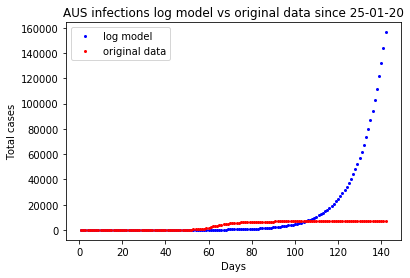

In [15]:
plt.plot(T, Y, 'bo', markersize=2, label='log model')
plt.plot(T, covid_data['cases'], 'ro', markersize=2, label='original data')
plt.legend()
plot_addons('AUS infections log model vs original data since ' + get_date_simple_format_str(aus_first_case_date) , 'Days', 'Total cases');

##### fitting log curve to our data (log model) - zoomed in

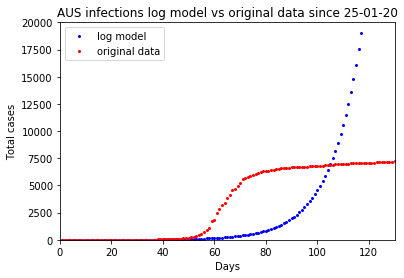

In [16]:
plt.plot(covid_data['time'], Y, 'bo', markersize=2, label='log model');
plt.plot(covid_data['time'], covid_data['cases'], 'ro', markersize=2, label='original data');
plt.xlim((0, 130));
plt.ylim((0, 20000));
plt.legend();
plot_addons('AUS infections log model vs original data since ' + get_date_simple_format_str(aus_first_case_date) , 'Days', 'Total cases');

Before we move on to a better fit, let's just look at what actual compounding exponential growth might look like, we might expect if a virus had an absolute perfect environment in a largr population they coudl get close to something like this initially.

And as we can see that this our growth in AUS was very slow and far form this.

##### Actual exponential growth

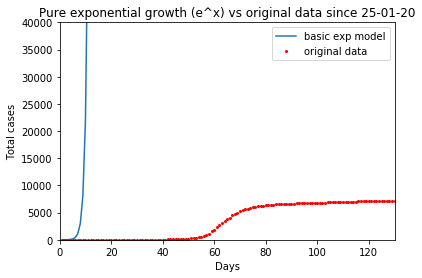

In [17]:
basic_exp = np.exp(np.linspace(1, len(covid_data['cases']), len(covid_data['cases'])))
plt.plot(covid_data['time'], basic_exp, label='basic exp model');
plt.plot(covid_data['time'], covid_data['cases'], 'ro', markersize=2, label='original data');
plt.xlim((0, 130));
plt.ylim((0, 40000));
plt.legend();
plot_addons('Pure exponential growth (e^x) vs original data since ' + get_date_simple_format_str(aus_first_case_date) , 'Days', 'Total cases');

#### Logistic Growth

With a litte bit of research, you will find Epidemiologist will say that a logistic function fits this type of growth much better.

##### Logistic function
y(t) = c / 1 + a * e^(-bt)<br>
t = time <br>
c = max value (limiting value) i.e. max possible infections<br>
b = growth coefficient<br>
a = constant involved in the initial amount of ppl<br>

This is particularly seen above from having variables that account for the fact that as the population becomes infected, the pool of possible people to infect is then reduced.

In Python I can do this using the scipy.optimize function. This will essentially work by me giving it a function (being the logistic function shown above), and giving it the real data we have, and it plays around with the variables until the line that it plot is as close as possible to the line plotted from the original data. It again Minimizes the Least Squares to do this.




In [18]:
# https://towardsdatascience.com/modeling-logistic-growth-1367dc971de2
# logistic function 
# y(t) = c / 1 + a * e^(-bt)
# t = time 
# c = max value (limiting value) i.e. max possible infections
# b = growth coefficient
# a = constant involved in the initial amount of ppl
#   i.e. c/(1+a) = 1 (initial number set to 1)
#                  therefore given some max we would get some c
#                  for exmaple a max of 1000ppl (c = 1000), with a starting amount of 1
#                  => 1000/(1+a) = 1, => a = 999

def logistic_func(t, a, b, c, off):
    return c / (1 + a*np.exp(-b*t))+off



In [19]:
bounds = (0, [1000000000., 3., 24000000., 2])

In [20]:
import scipy.optimize as optim
import math

opt_vars = None
cov = None

#we plan to use optimizer, therefore we need starting values
p0 = np.random.exponential(size=4)
p0


array([0.50879683, 1.1178455 , 1.10703659, 0.37295628])

In [21]:
opt_vars, cov = optim.curve_fit(logistic_func, covid_data['time'], covid_data['cases'], bounds=bounds, p0=p0)

print('optimized values (for minimizing least squares) a: {}, b: {}, c: {} d: {}'.format(*opt_vars))

optimized values (for minimizing least squares) a: 437884.0248575159, b: 0.20064550578791024, c: 6956.1201242945635 d: 6.602868265023999e-17


In [22]:
max_growth_t = math.log(opt_vars[0])/opt_vars[1]
max_growth_t

64.73959792848557

In [23]:
pop_initial_val = opt_vars[2]/(1+opt_vars[0])
pop_initial_val

0.015885722802596473

In [24]:
Y = logistic_func(covid_data['time'], *opt_vars)

##### Logistic modelling fitted to original data, plotted against original data

We can see that already this is a great fit, and if we were to suddenly have an outbreak with a new virus that acted similarly to covid, and we had responded similarly, we could expect to predict very well how many cases we would have on a certain date. 

Or of more interest, we might be able to use it currently to predict the effect of an outbreak in the future.

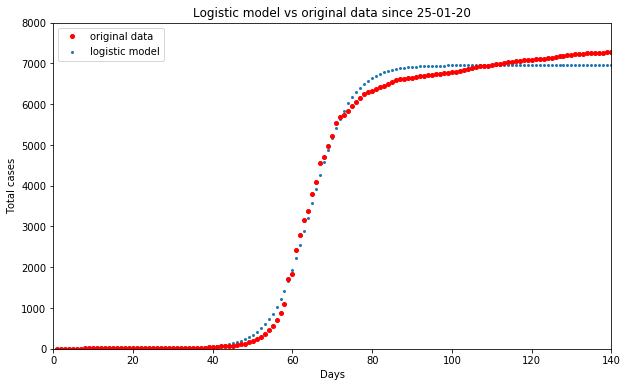

In [25]:
plt.figure(figsize=(10, 6))
plt.scatter(covid_data['time'], Y, label='logistic model', s=4);
plt.plot(covid_data['time'], covid_data['cases'], 'ro', markersize=4, label='original data');
plt.xlim((0, 140));
plt.ylim((0, 8000));
plt.legend();
plot_addons('Logistic model vs original data since ' + get_date_simple_format_str(aus_first_case_date) , 'Days', 'Total cases');

In [26]:
a = opt_vars[0]
b = opt_vars[1]
c = 24000000 #24mil
d = opt_vars[3]
Y = logistic_func(T, a, b, c, 1)
#t, a, b, c, off):

In [27]:

import matplotlib.dates as mdates
import datetime as dt


date = covid_data['Date']
date

1825   2020-01-25
1826   2020-01-26
1827   2020-01-27
1828   2020-01-28
1829   2020-01-29
          ...    
1962   2020-06-10
1963   2020-06-11
1964   2020-06-12
1965   2020-06-13
1966   2020-06-14
Name: Date, Length: 142, dtype: datetime64[ns]

In [28]:
date_str = ["".join(item) for item in date.astype(str)]

In [29]:
date_look_up = {}
for i in range(len(date_str)):
    date_look_up[date_str[i]] = i

def get_date_index(date, dict_lookup):
    return dict_lookup[date]

def get_date_from_index(index, dict_lookup):
    for key, val in dict_lookup.items():
        if index == val:
            return key
    return None


In [30]:
get_date_from_index(2, date_look_up)

'2020-01-27'

#### Actual expected logistic model not being fit to previous data (Given free reign the infectin rate in a logistic model would have been far more rapid)

Just to show how effective good measures against the spread of infeciton can be, I have plotted a pure logistic model with parameters such as the AUS population against the original data. Of course this doesn't truely represent a spread out population with different clusters of people (I'm sure epidemiologists have advanced methods for these thigns), but it shows again, that given a perfect environemnt using the logistic function, the outbreak would have been much worse. I'm also now introducing dates on the X-axis so we can start looking at the important milestones that might effect these curves.

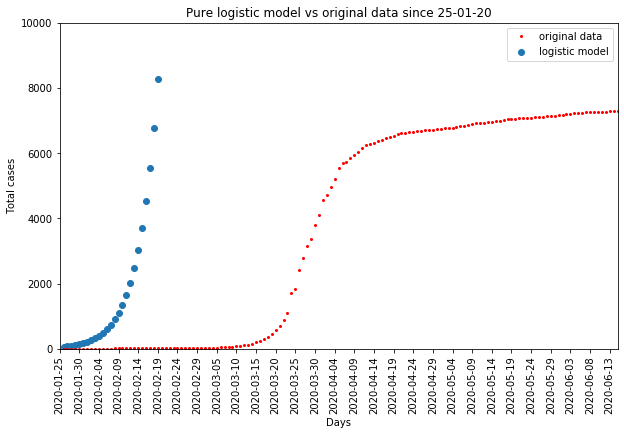

In [31]:
new_t = []
new_d = []
new_t = [i for i in range(len(T)) if i % 5 == 0]
new_d = [get_date_from_index(i, date_look_up) for i in new_t]


plt.figure(figsize=(10, 6))
plt.scatter(covid_data['time'], Y, label='logistic model');
plt.plot(covid_data['time'], covid_data['cases'], 'ro', markersize=2, label='original data');
plt.xticks(new_t, new_d, rotation='vertical')
plt.xlim((0, len(covid_data['time'])));
plt.ylim((0, 10000));
plt.legend();
plot_addons('Pure logistic model vs original data since ' + get_date_simple_format_str(aus_first_case_date) , 'Days', 'Total cases');

In [32]:
#map event date to x value
# https://www.mondaq.com/australia/operational-impacts-and-strategy/929622/timeline-of-key-social-economic-covid-19-events-affecting-australian-business
china_border = '2020-02-01'
international_self_iso_rule = '2020-03-16'
international_travel_ban = '2020-03-17'
indoor_gath_lt100 = '2020-03-18'
int_non_cit_res_ban = '2020-03-21'
lockdown_measure_1 = '2020-03-23'
lockdown_measure_2 = '2020-03-26'
lockdown_measure_3 = '2020-03-29'




In [33]:
#Test - 1st date with cases should return 0th Index
zeroth = get_date_index('2020-01-25', date_look_up)

#### Key goverment responses during the COVID-19 pandemic

Here we will look at the total cases, alongside what I personally consider crucial measures introduced by the AUS government during the crisis.
https://www.mondaq.com/australia/operational-impacts-and-strategy/929622/timeline-of-key-social-economic-covid-19-events-affecting-australian-business

**China border closure** = '2020-02-01'  --> https://www.scmp.com/news/asia/australasia/article/3048525/qantas-air-nz-suspend-china-flights-japan-declares <br>
Flights form mainland china banned.

**Isolation after int-flight** = '2020-03-16' <br>
Anyone travelling into Australia internationally, must isolate for 2-weeks.

**Int travel ban** = '2020-03-17' <br>
Ban on any international flights from Australia

**Ind Gather < 100** = '2020-03-18'<br>
Ban on any indoor gatherings with more than 100 people.

**Ban non-citizens arrival** = '2020-03-21' <br>
No international visitors (non-citizens) allowed entry to Australia.

**lockdown_measure_1** = '2020-03-23' <br>
Australia starts to lock down - bars, clubs, cinemas, places of worship, casinos and gyms are closed; schools start to close

**lockdown_measure_2** = '2020-03-26' <br>
Australia locks down some more - restaurants, cafes, food courts, auction houses are closed; open house inspections banned; weddings restricted to 5 people in total; funerals to 10 people

**lockdown_measure_3** = '2020-03-29' <br>
Australian Government urges Australians to stay at home other than for food shopping, medical or care needs, exercise or work/education that cannot be done at home
Australian Government states that no more than two people may be together in public.

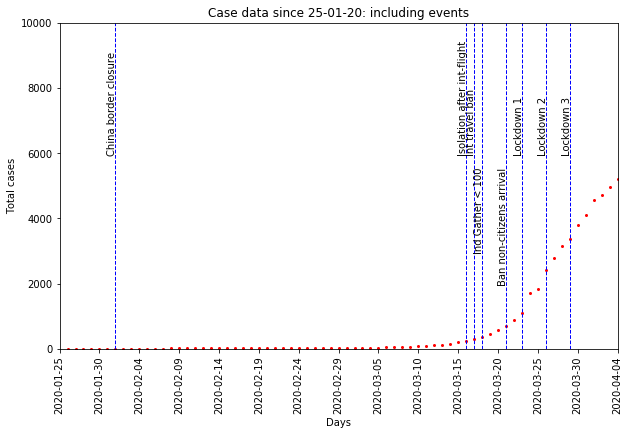

In [34]:

plt.figure(figsize=(10, 6))
#plt.scatter(T, Y, label='logistic model');
plt.plot(T, covid_data['cases'], 'ro', markersize=2, label='original data');
plt.xticks(new_t, new_d, rotation='vertical')
plt.xlim((0, 70));
plt.ylim((0, 10000));
#plt.legend();

def add_events_aus():
    plt.axvline(get_date_index(china_border, date_look_up), color='b', linestyle='--', lw=1)
    plt.text(get_date_index(china_border, date_look_up)-1,6000,'China border closure', rotation=90)

    plt.axvline(get_date_index(international_self_iso_rule, date_look_up),  color='b', linestyle='--', lw=1)
    plt.text(get_date_index(international_self_iso_rule, date_look_up)-1,6000,'Isolation after int-flight', rotation=90)

    plt.axvline(get_date_index(international_travel_ban, date_look_up),  color='b', linestyle='--', lw=1)
    plt.text(get_date_index(international_travel_ban, date_look_up)-1,6000,'Int travel ban', rotation=90)

    plt.axvline(get_date_index(indoor_gath_lt100, date_look_up),  color='b', linestyle='--', lw=1)
    plt.text(get_date_index(indoor_gath_lt100, date_look_up)-1,3000,'Ind Gather < 100', rotation=90)


    plt.axvline(get_date_index(int_non_cit_res_ban, date_look_up),  color='b', linestyle='--', lw=1)
    plt.text(get_date_index(int_non_cit_res_ban, date_look_up)-1,2000,'Ban non-citizens arrival', rotation=90)

    plt.axvline(get_date_index(lockdown_measure_1, date_look_up),  color='b', linestyle='--', lw=1)
    plt.text(get_date_index(lockdown_measure_1, date_look_up)-1,6000,'Lockdown 1', rotation=90)

    plt.axvline(get_date_index(lockdown_measure_2, date_look_up),  color='b', linestyle='--', lw=1)
    plt.text(get_date_index(lockdown_measure_2, date_look_up)-1,6000,'Lockdown 2', rotation=90)

    plt.axvline(get_date_index(lockdown_measure_3, date_look_up),  color='b', linestyle='--', lw=1)
    plt.text(get_date_index(lockdown_measure_3, date_look_up)-1,6000,'Lockdown 3', rotation=90)
add_events_aus()
plot_addons('Case data since ' + get_date_simple_format_str(aus_first_case_date) + ': including events' , 'Days', 'Total cases');

Looking at the above graph we can see how AUS reponded with virus control measures as the case severity increased. Of high importance though, is our earliest measure, the blocking of flights form mainland China. We can see that this pretty much stiffled and speedy progress of the virus, but eventually after 2 weeks, the few cases of virus in AUS started to affect the population.

Now out of interest, we would like to compare with another Western country that has not had as much success with controlling the virus, The UK.

In [42]:
covid_data_gb = pd.read_csv("total-cases-covid-19.csv")
#[print(i) for i in covid_data_gb['Entity'].unique()] - to look at names

# make an easier named column
if 'Total confirmed cases of COVID-19 (cases)'  in covid_data_gb.columns:
    covid_data_gb['cases'] = covid_data_gb['Total confirmed cases of COVID-19 (cases)']
    del covid_data_gb['Total confirmed cases of COVID-19 (cases)']


covid_data_gb = covid_data_gb[covid_data_gb['Entity'] == 'United Kingdom']
covid_data_gb['Date'] =pd.to_datetime(covid_data_gb['Date'])
#want to include the date for when china flights were closed
covid_data_gb = covid_data_gb[covid_data_gb['Date'] >= '2020-01-28']

covid_data_gb['time'] = np.linspace(1, len(covid_data_gb), len(covid_data_gb))

covid_data_gb.sort_values(by=['Date'])
covid_data_gb.head(5)


,Entity,Code,Date,cases,time
27177,United Kingdom,GBR,2020-01-28,0,1.0
27178,United Kingdom,GBR,2020-01-29,0,2.0
27179,United Kingdom,GBR,2020-01-30,0,3.0
27180,United Kingdom,GBR,2020-01-31,2,4.0
27181,United Kingdom,GBR,2020-02-01,2,5.0


You may notice I am picking data form slightly before the first cases, that is so in later charting I can include an earlier event from the UK's responses.

In [43]:
#british key dates
british_airways_susp_china_flights = '2020-01-28'
international_self_iso_rule_some_countries_gb = '2020-02-25'
self_iso_when_sick_gb = '2020-03-12'
#https://www.aljazeera.com/news/2020/03/coronavirus-travel-restrictions-border-shutdowns-country-200318091505922.html
advices_against_non_essential_travel_worldwide = '2020-03-17'
ordered_closure_pubs_resteraunts_school_gb =  '2020-03-20'
must_stay_home = '2020-03-24'

date = covid_data_gb['Date']
date_str_gb = ["".join(item) for item in date.astype(str)]
date_look_up_gb = {}
for i in range(len(date_str_gb)):
    date_look_up_gb[date_str_gb[i]] = i

In [44]:
max_t = max([len(covid_data_gb), len(covid_data)])
t_diff = abs(len(covid_data) - len(covid_data_gb))

Now I will also try and include some key dates form the UK's response to the virus. I will work of this link:
https://en.wikipedia.org/wiki/Timeline_of_the_COVID-19_pandemic_in_the_United_Kingdom
However I've found it hard to interpret the difference between a 'recommendation' and an actual law to be followed in some of these instances. However historically speaking, we know the UK was slow and soft in it's reponse to the virus, so we may interpret some of this key-dates as potentially softer implementations.

**british_airways_susp_china_flights** = '2020-01-28'<br>
British airways suspends all flights to/form mainland China.

**international_self_iso_rule_some_countries_gb** = '2020-02-25'<br>
Must self-solate if returning form Hubei, Iran, and certain regions of South Korea.

**self_iso_when_sick_gb** = '2020-03-12' #https://www.aljazeera.com/news/2020/03/coronavirus-travel-restrictions-border-shutdowns-country-200318091505922.html <br>
The government advises that anyone with a new continuous cough or a fever should self-isolate for seven days. Schools are asked to cancel trips abroad, and people over 70 and those with pre-existing medical conditions are advised to avoid cruises.

**advices_against_non_essential_travel_worldwide** = '2020-03-17' <br>
The Foreign and Commonwealth Office advises against all non-essential international travel due to the pandemic and the border restrictions put in place by many countries in response.

**ordered_closure_pubs_resteraunts_school_gb** = '2020-03-20'<br>
Closure of pubs, resteraunts, schools.

Following these, I feel that the further events, cancellations etc. are still quite soft, and not impactful (my subjective opinion), for exmaple Australia limiting public interactions to 2 ppl only at our peak of lockdown, looks very severe compared to some of the above. 

**must_stay_home** = '2020-03-24' <br>
For the first time, all of the UK's mobile networks send out a government text alert, ordering people to stay at home. The message reads: "GOV.UK CORONAVIRUS ALERT. New rules in force now: you must stay at home. More info and exemptions at gov.uk/coronavirus Stay at home. Protect the NHS. Save lives."


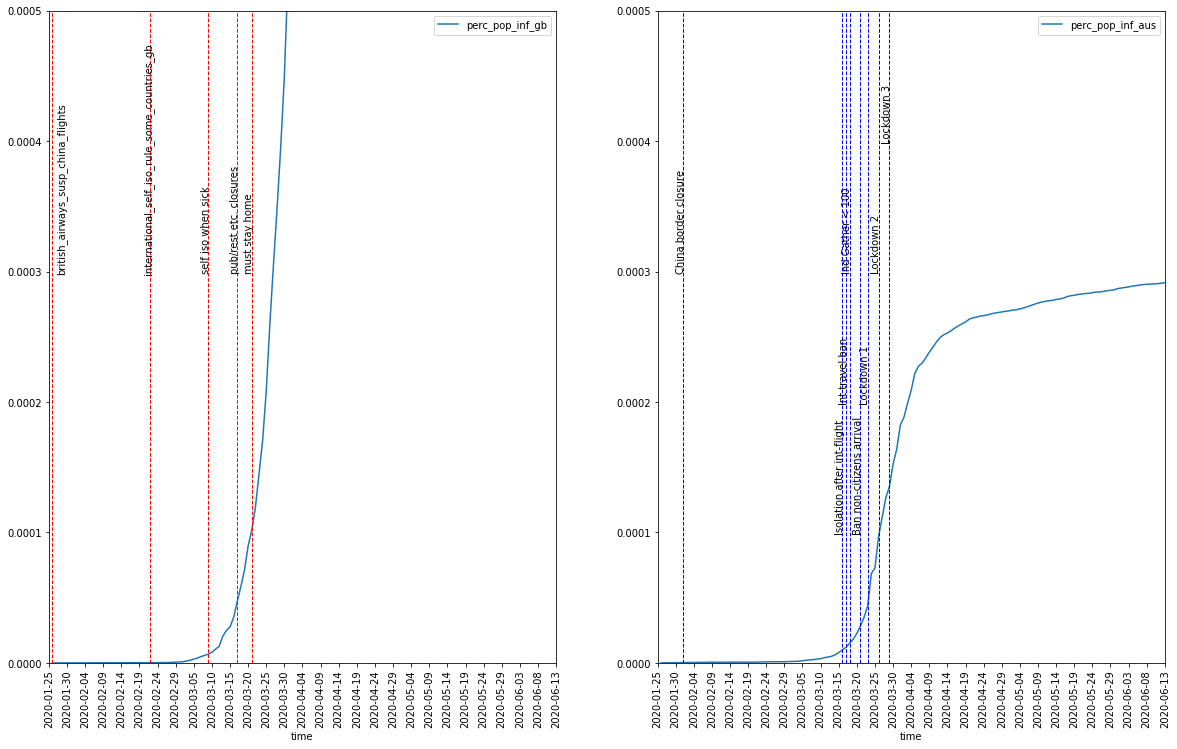

In [45]:
#make percentage population data instead
england_pop = 55980000
aus_pop = 25000000

#starting from earliest data
T = np.linspace(1, max_t, max_t)

#to allow the extra event in early

#gb_cases = np.concatenate((np.zeros(t_diff), np.array(covid_data_gb['cases'])))


perc_pop_inf_gb = np.true_divide(np.array(covid_data_gb['cases']), england_pop)
perc_pop_inf_aus = np.true_divide(np.array(covid_data['cases']), aus_pop)

covid_data_gb['perc_pop_inf_gb'] = perc_pop_inf_gb
covid_data['perc_pop_inf_aus']= perc_pop_inf_aus

fig = plt.figure(figsize=(20, 12))
#plt.title('title')
    #plt.xlabel(x_axis)
    #plt.ylabel(y_axis)

ax1 = fig.add_subplot(121)
ax1.set_xticks(new_t)
ax1.set_xticklabels(new_d)
#ax1.tick_params(axis='x', rotation=90)

ax1.set_xlim((0, 140));
ax1.set_ylim((0, 0.0005));
covid_data_gb.plot(ax=ax1, x='time', y='perc_pop_inf_gb', subplots=True)

#gb dates
ax1.axvline(get_date_index(british_airways_susp_china_flights, date_look_up_gb)+1,  color='r', linestyle='--', lw=1)
plt.text(get_date_index(british_airways_susp_china_flights, date_look_up_gb)+2,0.0003,'british_airways_susp_china_flights', rotation=90)

ax1.axvline(get_date_index(international_self_iso_rule_some_countries_gb, date_look_up_gb),  color='r', linestyle='--', lw=1)
plt.text(get_date_index(international_self_iso_rule_some_countries_gb, date_look_up_gb)-2,0.0003,'international_self_iso_rule_some_countries_gb', rotation=90)

ax1.axvline(get_date_index(self_iso_when_sick_gb, date_look_up_gb),  color='r', linestyle='--', lw=1)
plt.text(get_date_index(self_iso_when_sick_gb, date_look_up_gb)-2,0.0003,'self iso when sick', rotation=90)

ax1.axvline(get_date_index(must_stay_home, date_look_up_gb),  color='r', linestyle='--', lw=1)
plt.text(get_date_index(must_stay_home, date_look_up_gb)-2,0.0003,'must stay home', rotation=90)

ax1.axvline(get_date_index(ordered_closure_pubs_resteraunts_school_gb, date_look_up_gb),  color='r', linestyle='--', lw=1)
plt.text(get_date_index(ordered_closure_pubs_resteraunts_school_gb, date_look_up_gb)-2,0.0003,'pub/rest etc. closures', rotation=90)


ax2 = fig.add_subplot(122)

ax2.set_xlim((0, 140));
ax2.set_ylim((0, 0.0005));
covid_data.plot(ax=ax2, x='time', y='perc_pop_inf_aus', subplots=True)
ax2.set_xticks(new_t)
ax2.set_xticklabels(new_d)

#aus dates
ax2.axvline(get_date_index(china_border, date_look_up), color='b', linestyle='--', lw=1)
plt.text(get_date_index(china_border, date_look_up)-2,0.0003,'China border closure', rotation=90)

ax2.axvline(get_date_index(international_self_iso_rule, date_look_up),  color='b', linestyle='--', lw=1)
plt.text(get_date_index(international_self_iso_rule, date_look_up)-2,0.0001,'Isolation after int-flight', rotation=90)

ax2.axvline(get_date_index(international_travel_ban, date_look_up),  color='b', linestyle='--', lw=1)
plt.text(get_date_index(international_travel_ban, date_look_up)-2,0.0002,'Int travel ban', rotation=90)

ax2.axvline(get_date_index(indoor_gath_lt100, date_look_up),  color='b', linestyle='--', lw=1)
plt.text(get_date_index(indoor_gath_lt100, date_look_up)-2,0.0003,'Ind Gather < 100', rotation=90)


ax2.axvline(get_date_index(int_non_cit_res_ban, date_look_up),  color='b', linestyle='--', lw=1)
plt.text(get_date_index(int_non_cit_res_ban, date_look_up)-2,0.0001,'Ban non-citizens arrival', rotation=90)

ax2.axvline(get_date_index(lockdown_measure_1, date_look_up),  color='b', linestyle='--', lw=1)
plt.text(get_date_index(lockdown_measure_1, date_look_up)-2,0.0002,'Lockdown 1', rotation=90)

ax2.axvline(get_date_index(lockdown_measure_2, date_look_up),  color='b', linestyle='--', lw=1)
plt.text(get_date_index(lockdown_measure_2, date_look_up)-2,0.0003,'Lockdown 2', rotation=90)

ax2.axvline(get_date_index(lockdown_measure_3, date_look_up),  color='b', linestyle='--', lw=1)
plt.text(get_date_index(lockdown_measure_3, date_look_up)-2,0.0004,'Lockdown 3', rotation=90)
    

for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=90)
    


In [46]:
active_VIC_cases = pd.read_csv('active_cases_VIC_june.csv')
active_VIC_cases

,Date,Active Cases
0,15/06/2020,40
1,16/06/2020,51
2,17/06/2020,70
3,18/06/2020,81
4,19/06/2020,91
5,20/06/2020,110
6,21/06/2020,121
7,22/06/2020,125
8,23/06/2020,131
9,24/06/2020,141


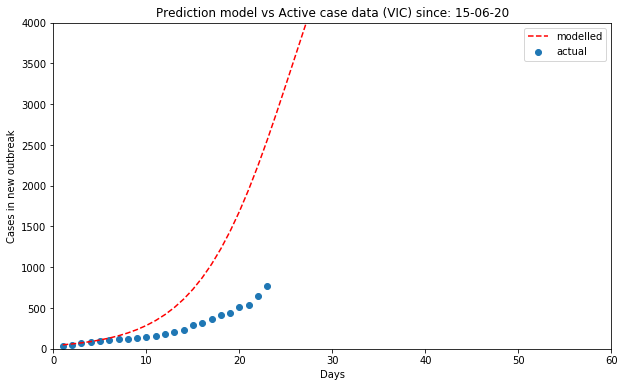

In [48]:
#new outbreak ~June 15 (15 new cases)
# logistic function 
# y(t) = c / 1 + a * e^(-bt)
# t = time 
# c = max value (limiting value) i.e. max possible infections
# b = growth coefficient
# a = constant involved in the initial amount of ppl
#   i.e. c/(1+a) = 1 (initial number set to 1)
#                  therefore given some max we would get some c
#                  for exmaple a max of 1000ppl (c = 1000), with a starting amount of 1
#                  => 1000/(1+a) = 1, => a = 999
# def logistic_func(t, a, b, c, off):

#382 #number of active cases on June 15 (as per stats online) https://www.worldometers.info/coronavirus/country/australia/
a = opt_vars[0]
b = opt_vars[1]
c = opt_vars[2]

#https://covidlive.com.au/report/daily-active-cases/vic
#if c / (1+a) = num_ppl
#we know at estimated outbreak time num_ppl(ACTIVE) = 40
#then -> new_a = (c-382)/382
#change to population is negligible at this stage (unless ppl have heard immunity and there are many who have already had the virus)
number_active_cases = 40
opt_vars[0] = (c-number_active_cases)/number_active_cases

num_days_ahead = 140

#set cases to 0 for graph - but model should still take into account current number
#this number is only used to plot the real data
#since_outbreak_cases['cases'] = since_outbreak_cases['cases'] - covid_data['cases'].iloc[i]
T = np.linspace(1,  num_days_ahead, num_days_ahead)
modelled_outbreak = logistic_func(T, *opt_vars)


plt.figure(figsize=(10, 6))
plt.scatter(T[0:len(active_VIC_cases)], active_VIC_cases['Active Cases'], label='actual');
plt.plot(T, modelled_outbreak, 'r--', markersize=2, label='modelled');
#plt.plot(T, covid_data['cases'][0:len(T)], 'go', markersize=2, label='original growth in first 50 days');
plt.xlim((0, 60));
plt.ylim((0, 4000));
plt.legend();
plot_addons('Prediction model vs Active case data (VIC) since: ' + '15-06-20' , 'Days', 'Cases in new outbreak');

In [ ]:
#Need to actual model again but off Victorian numbers
